In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import pystan
import arviz

In [128]:
df = pd.read_csv("../data/processed_data.csv", parse_dates=["date"])

df["year"] = df["date"].dt.year

train = df.loc[df["date"] < "2019-01-01"]
test = df.loc[df["date"] >= "2019-01-01"]

### Get a ranking for each player based on their averge elo over the period

Can also look at variability in elo over the period (later)

First we grab all the ids in the training set:

In [129]:
train_ids = list(set(train["white_id"].values).union(set(train["black_id"].values)))

num_players = len(train_ids)
num_games = len(train)

Construct a prior score by using the average elo ranking of a player during the period.

In [130]:
train_id_to_avg_elo = train.groupby("white_id")["white_elo"].mean().to_dict()

train_id_to_avg_elo_ranked = {k: v for k, v in sorted(train_id_to_avg_elo.items(), key=lambda item: item[1], reverse=True)}
raw_prior_score = np.arange(len(train_ids), 0, -1)
prior_score = (raw_prior_score - np.mean(raw_prior_score)) / (2 * np.std(raw_prior_score, ddof=1))
ranking_dict = {k: v for k, v in zip(train_id_to_avg_elo_ranked.keys(), range(1, len(train_ids) + 1))}

In [131]:
train["white_prior_rank"] = train["white_id"].apply(lambda x: ranking_dict[x])
train["black_prior_rank"] = train["black_id"].apply(lambda x: ranking_dict[x])
white_fave = train["white_prior_rank"] < train["black_prior_rank"]

/opt/anaconda/envs/Python3/lib/python3.6/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':
/opt/anaconda/envs/Python3/lib/python3.6/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel import kernelapp as app


In [132]:
def create_cols(df, mask, white_col, black_col, fave_name, underdog_name):
    df[fave_name] = df.loc[mask, white_col]
    df.loc[~mask, fave_name] = df.loc[~mask, black_col]
    df[underdog_name] = df.loc[~mask, white_col]
    df.loc[mask, underdog_name] = df.loc[mask, black_col]

In [133]:
create_cols(train, white_fave, "white_id", "black_id", "fave_id", "underdog_id")
create_cols(train, white_fave, "white_prior_rank", "black_prior_rank", "fave_rank", "underdog_rank")
create_cols(train, white_fave, "white_score", "black_score", "fave_score", "underdog_score")

/opt/anaconda/envs/Python3/lib/python3.6/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel import kernelapp as app
/opt/anaconda/envs/Python3/lib/python3.6/site-packages/ipykernel/__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [134]:
train.head()
train["fave_outcome"] = (3 - train["fave_score"]*2).astype(int)

/opt/anaconda/envs/Python3/lib/python3.6/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel import kernelapp as app


In [135]:
train["white_is_fave"] = (train["white_id"] == train["fave_id"]).astype(int)

/opt/anaconda/envs/Python3/lib/python3.6/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':


In [136]:
train["abs_rank_diff"] = np.abs(train["white_prior_rank"].values - train["black_prior_rank"].values)
train["fave_underdog_score_diff"] = train["fave_score"].values - train["underdog_score"].values
train_sorted = train.sort_values(["abs_rank_diff", "fave_id"], ascending=[False, True])

/opt/anaconda/envs/Python3/lib/python3.6/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':
/opt/anaconda/envs/Python3/lib/python3.6/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel import kernelapp as app


### 1. Fit a continuous likelihood model

To model the favourite minus underdog score.

In [10]:
model = pystan.StanModel("../stan_models/basic_model.stan")

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_98274414d574c494145a37e09b068514 NOW.


In [11]:
stan_data = {
    "num_players": num_players,
    "num_games": num_games,
    "prior_score": prior_score,
    "fave_rank": train_sorted["fave_rank"].values.astype(int),
    "underdog_rank": train_sorted["underdog_rank"].values.astype(int),
    "fave_score": train_sorted["fave_score"].values,
    "underdog_score": train_sorted["underdog_score"].values
}

In [12]:
fit = model.sampling(data=stan_data)

To run all diagnostics call pystan.check_hmc_diagnostics(fit)


In [13]:
params = fit.extract(permuted=True)

inference_data = arviz.convert_to_inference_data(fit)
summary_df = arviz.summary(inference_data).reset_index().rename(columns={"index":"parameter"})

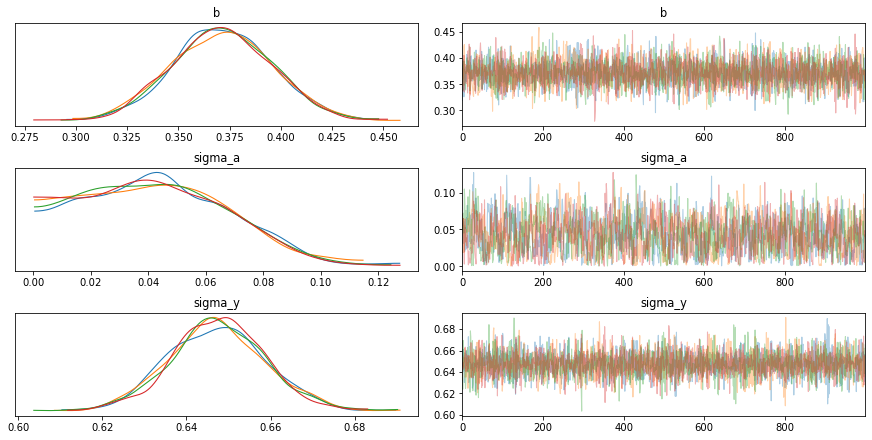

In [14]:
arviz.plot_trace(inference_data, var_names=["b", "sigma_a", "sigma_y"]);

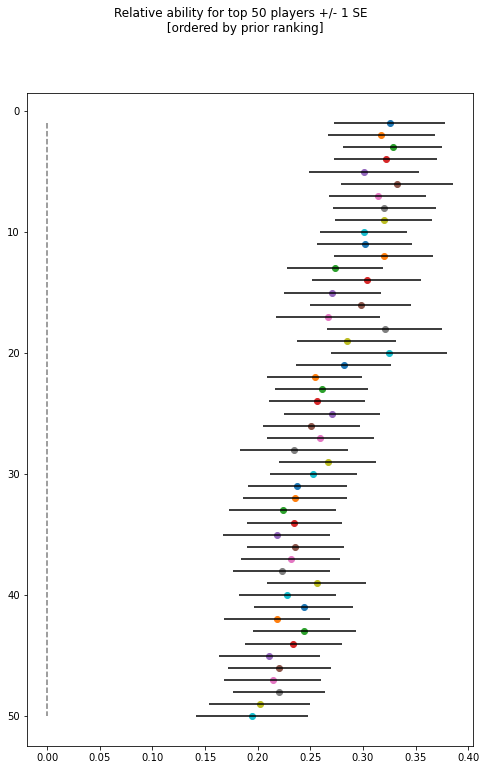

In [16]:
fig, ax = plt.subplots(figsize=(8, 12))
plot_top_n_players = 50

for i in range(plot_top_n_players):
    a_mean = params["a"][:, i].mean()
    a_sd = float(summary_df.loc[summary_df["parameter"] == f"a[{i}]", "sd"])
    ax.scatter(a_mean, i + 1)
    ax.hlines(i + 1, a_mean - a_sd, a_mean + a_sd)
    
plt.vlines(0, 1, plot_top_n_players, linestyle="--", alpha=0.5);
plt.gca().invert_yaxis();
plt.suptitle(f"Relative ability for top {plot_top_n_players} players +/- 1 SE \n [ordered by prior ranking]");

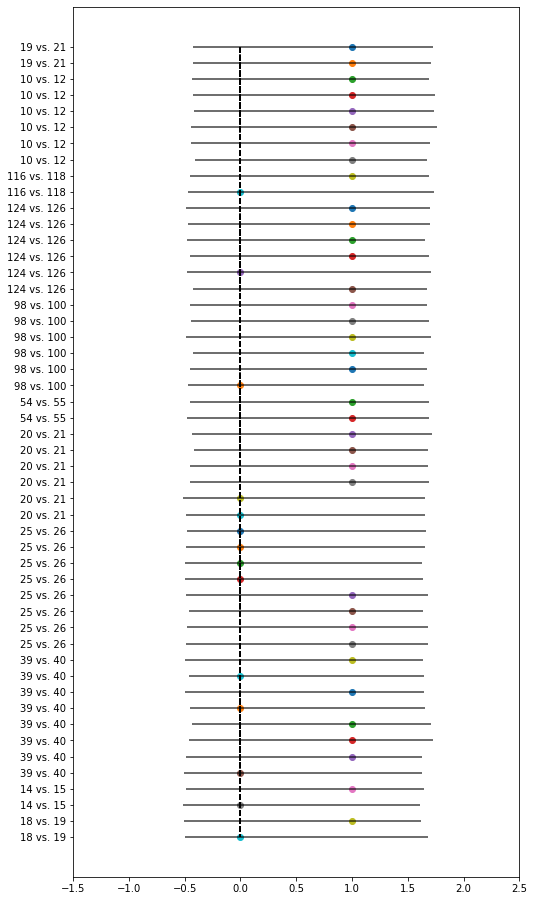

In [18]:
q = 0.90
plot_n = 50
reverse = True

plot_df = train_sorted if not reverse else train_sorted.sort_values(["abs_rank_diff", "fave_id"], ascending=[True, False])
ranks = [f"{a} vs. {b}" for a, b in zip(train_sorted["fave_rank"].values.astype(int), train_sorted["underdog_rank"].values.astype(int))]

fig, ax = plt.subplots(figsize=(8, 16))
for i in range(plot_n):
    lq, uq = np.quantile(params["ypred"][:, i], q=[(1-q)/2, q + (1-q)/2])
    ax.scatter(train_sorted["fave_underdog_score_diff"].values[i], i+1)
    ax.hlines(i + 1, lq, uq, alpha=0.75)
    ax.vlines(0, 1, plot_n, linestyle="--", alpha=0.5)
plt.gca().invert_yaxis();
plt.xlim(-1.5, 2.5);
if not reverse:
    plt.yticks(range(1, plot_n + 1), ranks[:plot_n]);
else:
    plt.yticks(range(1, plot_n + 1), ranks[-plot_n:]);

This model is pretty crap and it's not clear how to make predictions from it.

### 2. Ordered logistic model

Now we'll fit an ordered logistic model.

In [118]:
ordered_model = pystan.StanModel("../stan_models/ordered_logistic.stan")

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_cf3aacba09e4d56bb734ecf262c4743e NOW.


In [138]:
stan_data_ordered = {
    "num_players": num_players,
    "num_games": num_games,
    "K": 3,
    "prior_score": prior_score,
    "fave_rank": train_sorted["fave_rank"].values.astype(int),
    "underdog_rank": train_sorted["underdog_rank"].values.astype(int),
    "y": train_sorted["fave_outcome"].values.astype(int),
    "white_is_fave": train_sorted["white_is_fave"].values.astype(int)
}

In [139]:
ordered_fit = ordered_model.sampling(data=stan_data_ordered, chains=2)

To run all diagnostics call pystan.check_hmc_diagnostics(fit)


In [140]:
ordered_params = ordered_fit.extract(permuted=True)

ordered_inference_data = arviz.convert_to_inference_data(ordered_fit)
ordered_summary_df = arviz.summary(ordered_inference_data).reset_index().rename(columns={"index":"parameter"})

In [143]:
ordered_summary_df.head(7)

,parameter,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
0,b,-1.093,0.113,-1.318,-0.900,0.003,0.002,1944.0,1944.0,1958.0,1243.0,1.00
1,sigma_a,0.163,0.081,0.002,0.294,0.004,0.003,446.0,446.0,447.0,787.0,1.01
2,c[0],-1.630,0.099,-1.813,-1.434,0.002,0.002,1964.0,1964.0,1979.0,1265.0,1.00
3,c[1],1.011,0.098,0.838,1.199,0.002,0.001,2557.0,2495.0,2591.0,1665.0,1.00
4,w,-0.723,0.097,-0.901,-0.544,0.002,0.001,2888.0,2888.0,2891.0,1457.0,1.00
5,raw_a[0],-0.168,1.012,-1.954,1.764,0.017,0.025,3760.0,795.0,3746.0,1120.0,1.00
6,raw_a[1],0.038,0.982,-1.842,1.845,0.016,0.029,3812.0,573.0,3904.0,1285.0,1.00


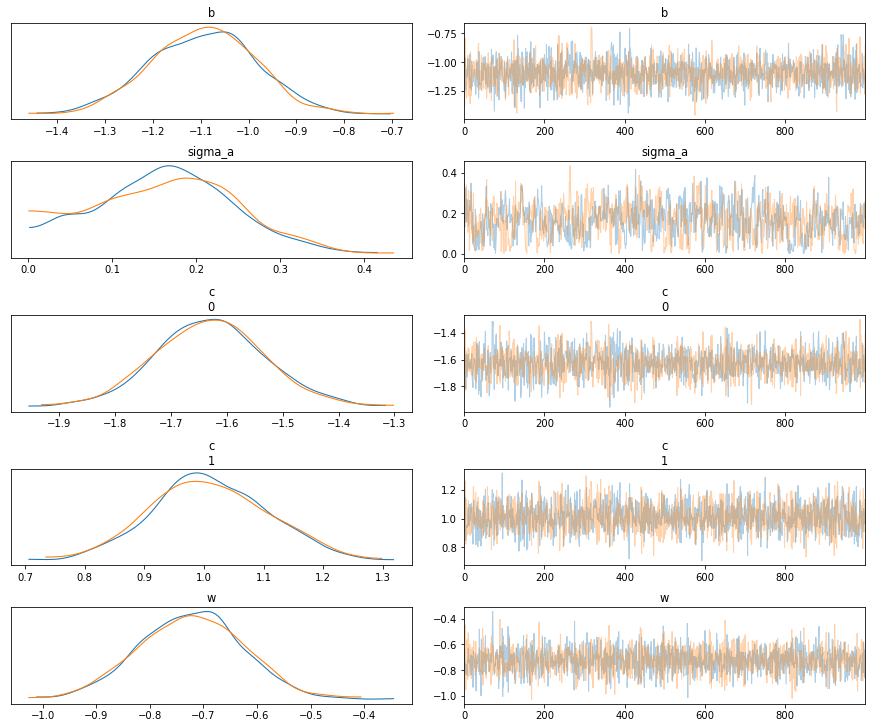

In [145]:
arviz.plot_trace(ordered_inference_data, var_names=["b", "sigma_a", "c", "w"]);

#### Plotting

Outcome 1 indicates that the favourite won.

The ability parameters are the "wrong" way around atm.

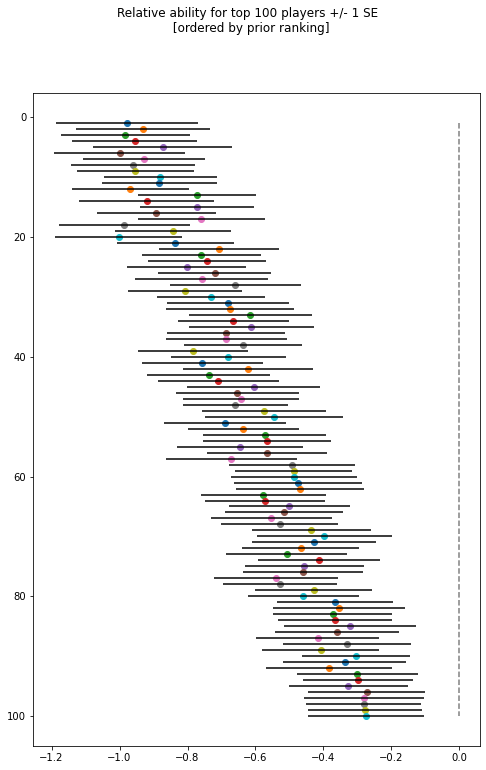

In [146]:
fig, ax = plt.subplots(figsize=(8, 12))
plot_top_n_players = 100

for i in range(plot_top_n_players):
    a_mean = ordered_params["a"][:, i].mean()
    a_sd = float(ordered_summary_df.loc[ordered_summary_df["parameter"] == f"a[{i}]", "sd"])
    ax.scatter(a_mean, i + 1)
    ax.hlines(i + 1, a_mean - a_sd, a_mean + a_sd)
    
plt.vlines(0, 1, plot_top_n_players, linestyle="--", alpha=0.5);
plt.gca().invert_yaxis();
plt.suptitle(f"Relative ability for top {plot_top_n_players} players +/- 1 SE \n [ordered by prior ranking]");

In [147]:
levels = [1, 2, 3]
out = []
for l in levels:
    out.append(np.sum(ordered_params["ypred"] == l, 0))
out = np.array(out).T
out_prob = out/np.mean(out.sum(1))

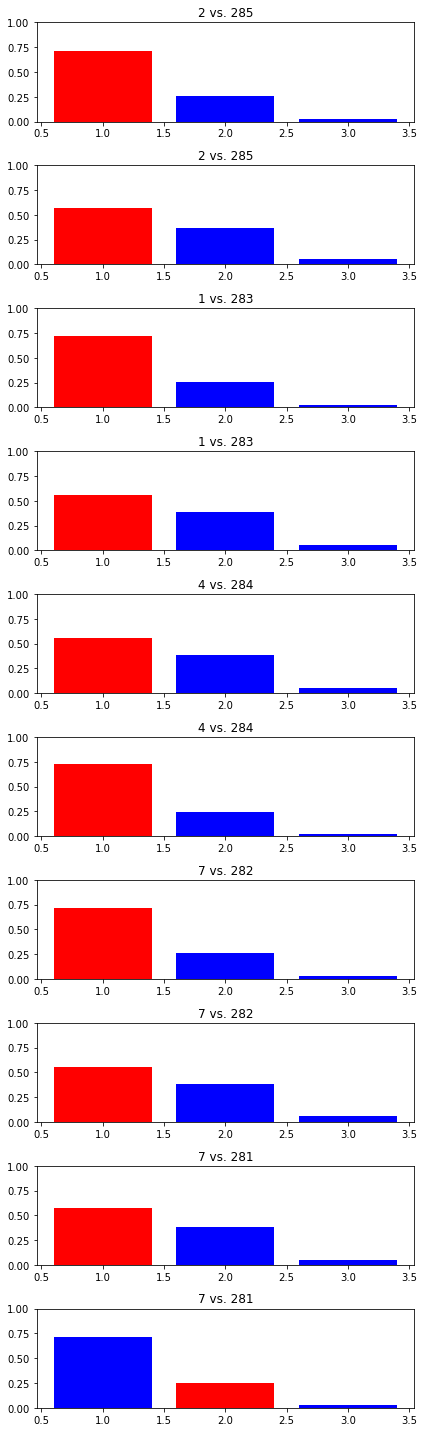

In [148]:
plot_n = 10
reverse = False
colors = ["blue"]*3

plot_df = train_sorted if not reverse else train_sorted.sort_values(["abs_rank_diff", "fave_id"], ascending=[True, False])
ranks = [f"{a} vs. {b}" for a, b in zip(train_sorted["fave_rank"].values.astype(int), train_sorted["underdog_rank"].values.astype(int))]

fig, ax = plt.subplots(plot_n, 1, figsize=(6, 20))
ax = ax.ravel()

for i in range(plot_n):
    bar_colors = colors.copy()
    bar_colors[train_sorted["fave_outcome"].values[i] - 1] = "red"
    ax[i].bar(range(1, 4), out_prob[i, :], color=bar_colors);
    ax[i].set_title(f"{ranks[i]}");
    ax[i].set_ylim(0, 1);
plt.tight_layout();

Let's look at how many we got right:

In [158]:
cls_pred = np.argmax(out_prob, 1) + 1

In [159]:
np.mean(np.abs(train_sorted["fave_outcome"] - cls_pred) == 0)

0.5566093657379965

In [160]:
np.mean(np.abs(train_sorted["fave_outcome"] - cls_pred) == 2)

0.008298755186721992

In [161]:
np.mean(np.abs(train_sorted["fave_outcome"] - cls_pred) == 1)

0.4350918790752816

So we rarely get the wrong outcome...but we do confuse wins and draws quite a lot.